In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import pandas as pd
import numpy as np
from pathlib import Path
from typing import *
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import sys
sys.path.append("../lib")

In [4]:
from bert_utils import Config, BertPreprocessor

C:\Users\Mac\anaconda3\envs\sat\lib\importlib\_bootstrap.py:219: RuntimeWarning: greenlet.greenlet size changed, may indicate binary incompatibility. Expected 152, got 144
  return f(*args, **kwds)
C:\Users\Mac\anaconda3\envs\sat\lib\importlib\_bootstrap.py:219: RuntimeWarning: greenlet.greenlet size changed, may indicate binary incompatibility. Expected 152, got 144
  return f(*args, **kwds)
C:\Users\Mac\anaconda3\envs\sat\lib\importlib\_bootstrap.py:219: RuntimeWarning: greenlet.greenlet size changed, may indicate binary incompatibility. Expected 152, got 144
  return f(*args, **kwds)
C:\Users\Mac\anaconda3\envs\sat\lib\importlib\_bootstrap.py:219: RuntimeWarning: greenlet.greenlet size changed, may indicate binary incompatibility. Expected 152, got 144
  return f(*args, **kwds)
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [5]:
config = Config(
    model_type="bert-base-cased",
    max_seq_len=128,
)

In [6]:
processor = BertPreprocessor(config.model_type, config.max_seq_len)

In [7]:
from pytorch_pretrained_bert import BertConfig, BertForMaskedLM
model = BertForMaskedLM.from_pretrained(config.model_type)
model.eval() # Important! Disable dropout

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
   

In [9]:
from tokenizers import BertWordPieceTokenizer
tokenizer = BertWordPieceTokenizer("./bert-base-cased-vocab.txt")
tokenizer

Tokenizer(vocabulary_size=28996, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=True, wordpieces_prefix=##)

In [10]:
from pytorch_pretrained_bert import BertTokenizer

tokenizer = BertTokenizer.from_pretrained(config.model_type)

The pre-trained model you are loading is a cased model but you have not set `do_lower_case` to False. We are setting `do_lower_case=False` for you but you may want to check this behavior.


In [22]:
len(tokenizer.vocab)

28996

In [15]:
import json
l = []
with open('./professions.json','r',encoding='utf8')as fp:
    json_data = json.load(fp)
    
    for d in range(len(json_data)):
        l.append(json_data[d][0])
#print(l)
    #print(json_data[0][0])
professions_variants_pl = []
professions_variants_cap = []
professions_variants_upper = []
def plural(word):
    if word.endswith('y'):
        return word[:-1] + 'ies'
    elif word[-1] in 'sx' or word[-2:] in ['sh', 'ch']:
        return word + 'es'
    elif word.endswith('an'):
        return word[:-2] + 'en'
    else:
        return word + 's'
    
for word in l:
    professions_variants_pl.append(plural(word))
    professions_variants_cap.append(word.capitalize())
    professions_variants_upper.append(word.upper())
print(len(professions_variants_pl))
print(len(professions_variants_cap))
print(len(professions_variants_upper))
    

320
320
320


In [16]:
import re
def safe_word(w):
    # ignore words with numbers, etc.
    # [a-zA-Z\.'_\- :;\(\)\]] for emoticons
    return (re.match(r"^[a-zA-Z_]*$", w) and len(w) < 20 and not re.match(r"^_*$", w))

def netural_word(w):
    # ignore words with numbers, etc.
    # [a-zA-Z\.'_\- :;\(\)\]] for emoticons
    return (re.match(r"^[a-z_]*$", w) and len(w) < 20 and not re.match(r"^_*$", w))

def limit_vocab(model, exclude = None):
    vocab_limited = []
    vocab_neutral = []
    for w in list(tokenizer.vocab.keys()): 
        if safe_word(w) == True:
             vocab_limited.append(w)
        if netural_word(w) == True:
            vocab_neutral.append(w)
    return vocab_limited

lim = limit_vocab(list(tokenizer.vocab.keys()))

In [17]:
len(lim)

20641

#### measure_1_LPBS

In [11]:
def get_logits(sentence: str) -> np.ndarray:
    return model(processor.to_bert_model_input(sentence))[0, :, :].cpu().detach().numpy()

In [12]:
def softmax(arr, axis=1):
    e = np.exp(arr)
    return e / e.sum(axis=axis, keepdims=True)

In [13]:
from collections import defaultdict

def get_mask_fill_logits(sentence: str, words: Iterable[str],
                         use_last_mask=False, apply_softmax=False) -> Dict[str, float]:
    mask_i = processor.get_index(sentence, "[MASK]", last=use_last_mask)
    logits = defaultdict(list)
    out_logits = get_logits(sentence)
    if apply_softmax: 
        out_logits = softmax(out_logits)
    return {w: out_logits[mask_i, processor.token_to_index(w)] for w in words}

In [14]:
import pandas as pd
def bias_score(sentence: str, gender_words: Iterable[str], 
               word: str, gender_comes_first=True) -> Dict[str, float]:
    """
    Input a sentence of the form "GGG is XXX"
    XXX is a placeholder for the target word
    GGG is a placeholder for the gendered words (the subject)
    We will predict the bias when filling in the gendered words and 
    filling in the target word.
    
    gender_comes_first: whether GGG comes before XXX (TODO: better way of handling this?)
    """
    # probability of filling [MASK] with "he" vs. "she" when target is "programmer"
    ###fw,mw（实际顺序）
    mw, fw = gender_words
    subject_fill_logits = get_mask_fill_logits(
        sentence.replace("XXX", word).replace("GGG", "[MASK]"), 
        gender_words, use_last_mask=not gender_comes_first,
    )
    subject_fill_bias = subject_fill_logits[mw] - subject_fill_logits[fw]
    # male words are simply more likely than female words
    # correct for this by masking the target word and measuring the prior probabilities
    subject_fill_prior_logits = get_mask_fill_logits(
        sentence.replace("XXX", "[MASK]").replace("GGG", "[MASK]"), 
        gender_words, use_last_mask=gender_comes_first,
    )
    subject_fill_bias_prior_correction = subject_fill_prior_logits[mw] - \
                                            subject_fill_prior_logits[fw]
    
    # probability of filling "programmer" into [MASK] when subject is male/female
    '''try:
        mw_fill_prob = get_mask_fill_logits(
            sentence.replace("GGG", mw).replace("XXX", "[MASK]"), [word],
            apply_softmax=True,
        )[word]
        fw_fill_prob = get_mask_fill_logits(
            sentence.replace("GGG", fw).replace("XXX", "[MASK]"), [word],
            apply_softmax=True,
        )[word]
        # We don't need to correct for the prior probability here since the probability
        # should already be conditioned on the presence of the word in question
        ## 用对数优势比来衡量概率的差异
        tgt_fill_bias = np.log(mw_fill_prob / fw_fill_prob)
    except Exception as e:
        #print(e)
        tgt_fill_bias = np.nan # TODO: handle multi word case'''
    return subject_fill_bias,subject_fill_bias_prior_correction,subject_fill_bias - subject_fill_bias_prior_correction#,tgt_fill_bias
       

In [38]:
# To get mean and std
subject_fill_bias = []
subject_fill_bias_prior_correction = []
an = []
tgt_fill_bias = []      
import pandas as pd
# make list defining gender pairs
# for measures & this list, + = female, - = male
def_pairs = [('she','he'), ('her', 'his'), ('woman', 'man'), 
              ('herself', 'himself'),('daughter', 'son'), ('mother', 'father'), ('gal','guy'), 
              ('girl', 'boy'), ('female', 'male')]
#print(def_pairs[0])
for w in def_pairs:  
    for i in lim[52:]:
        a,b,c= bias_score("GGG is a XXX.", [w[0], w[1]], i)
        #subject_fill_bias.append(a)
        #subject_fill_bias_prior_correction.append(b)
        an.append(c)
        #tgt_fill_bias.append(d)    
oa_mean = np.mean(an)
oa_std = np.std(an)
print("overall mean and std:", oa_mean, oa_std)  

overall mean and std: -0.54284024 1.3037229


professor
[-0.8061633, 0.839221, -2.0462284, -0.07825041, -0.90341747, -1.7006025, 1.5541481, -0.99759185, -1.0842367]
professors
[-0.91115713, 0.45574856, -2.261635, -0.2091906, -1.4805918, -1.7691853, -0.37458634, -1.5313267, -1.1482763]
Professor
[-0.7639613, 0.86977863, -2.0090013, -0.104157686, -0.87853754, -1.6557273, 1.6216544, -1.0998623, -0.8791299]
PROFESSOR
[-0.84019613, 0.03293872, -3.0419378, -0.33813715, -1.1136804, -0.649625, 1.3506792, -1.5665492, -0.8767464]


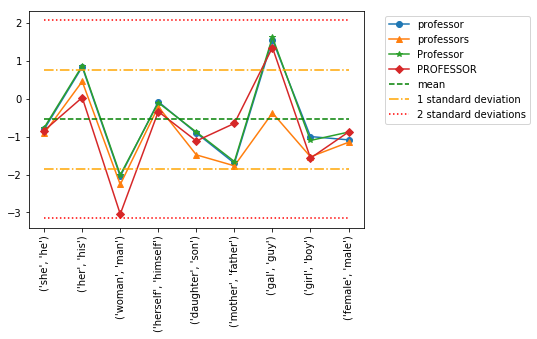

In [20]:
# fn to get variant forms of profession (eg for doctor, returns doctor, doctors, Doctor, DOCTOR)   
def_pairs = [('she','he'), ('her', 'his'), ('woman', 'man'), 
              ('herself', 'himself'),('daughter', 'son'), ('mother', 'father'), ('gal','guy'), 
              ('girl', 'boy'), ('female', 'male')]
oa_mean = -0.54284024
oa_std = 1.3037229
def plural(word):
    if word.endswith('y'):
        return word[:-1] + 'ies'
    elif word[-1] in 'sx' or word[-2:] in ['sh', 'ch']:
        return word + 'es'
    elif word.endswith('an'):
        return word[:-2] + 'en'
    else:
        return word + 's'
def prof_words(prof):
    prof_words = [prof]
    prof_words.append(plural(prof))
    prof_words.append(prof.capitalize())
    prof_words.append(prof.upper())
    return prof_words

length = len(def_pairs)
x = np.arange(length)
fig = plt.figure()
ax = plt.subplot(111)
graph_types = ["-o", "-^", "-*", "-D"]
#scores = ["-3.0180273","-3.0180273","0.171636","-3.0180273","-3.0180273","-3.0180273","-3.0180273","-3.0180273","-3.0180273","-3.0180273"]
#plt.plot(x, scores, graph_types[0], label = word)
gword_list = prof_words("professor")
for i,word in enumerate(gword_list):
    print(word)
    graph_type = graph_types[i]      
    #plt.title("DB/WA")
    scores = ([bias_score("GGG is a XXX.", [pair[0], pair[1]], word)[2] for pair in def_pairs])
    print(scores)
    plt.plot(x, scores, graph_types[i], label = word)
            
plt.plot(x, [oa_mean for i in range(length)], "g--", label = "mean")
plt.plot(x, [oa_mean-oa_std for i in range(length)], "-.",color = "orange", label = "1 standard deviation")
plt.plot(x, [oa_mean+oa_std for i in range(length)],  "-.",color = "orange", label =  "")
plt.plot(x, [oa_mean-2*oa_std for i in range(length)],  "r:", label = "2 standard deviations")
plt.plot(x, [oa_mean+2*oa_std for i in range(length)],  "r:", label = "")
plt.xticks(x, def_pairs, rotation='vertical')

#if leg == True:
plt.legend()
ax.legend(bbox_to_anchor=(1.05, 1.0))
plt.show()    

nurse
[2.5391269, 3.8959286, 0.54591227, 2.2980382, 2.010731, 1.3242395, 3.5939198, 1.8953564, 1.3070959]
nurses
[1.2493315, 2.3699148, -0.47898763, 1.5079561, 0.4910698, 0.06289029, 1.8275244, 0.30963588, 0.25542974]
Nurse
[1.0257063, 2.5027378, -1.0707276, 1.3611052, 0.4969778, -8.106232e-05, 2.0324752, 0.3526683, 0.22165132]
NURSE
[-0.58010197, 0.20757723, -3.216601, -0.39487672, -1.0980699, -0.37130916, -0.4583583, -1.4594082, -0.74881685]


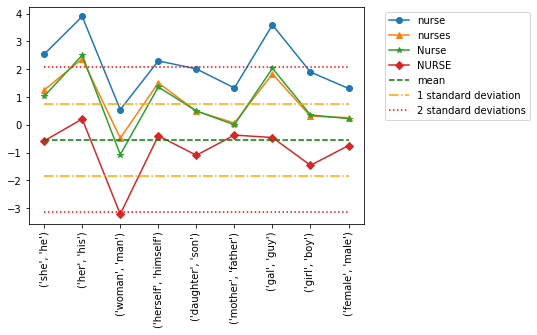

In [25]:
# fn to get variant forms of profession (eg for doctor, returns doctor, doctors, Doctor, DOCTOR)   
def_pairs = [('she','he'), ('her', 'his'), ('woman', 'man'), 
              ('herself', 'himself'),('daughter', 'son'), ('mother', 'father'), ('gal','guy'), 
              ('girl', 'boy'), ('female', 'male')]
oa_mean = -0.54284024
oa_std = 1.3037229
def plural(word):
    if word.endswith('y'):
        return word[:-1] + 'ies'
    elif word[-1] in 'sx' or word[-2:] in ['sh', 'ch']:
        return word + 'es'
    elif word.endswith('an'):
        return word[:-2] + 'en'
    else:
        return word + 's'
def prof_words(prof):
    prof_words = [prof]
    prof_words.append(plural(prof))
    prof_words.append(prof.capitalize())
    prof_words.append(prof.upper())
    return prof_words

length = len(def_pairs)
x = np.arange(length)
fig = plt.figure()
ax = plt.subplot(111)
graph_types = ["-o", "-^", "-*", "-D"]
#scores = ["-3.0180273","-3.0180273","0.171636","-3.0180273","-3.0180273","-3.0180273","-3.0180273","-3.0180273","-3.0180273","-3.0180273"]
#plt.plot(x, scores, graph_types[0], label = word)
gword_list = prof_words("nurse")
for i,word in enumerate(gword_list):
    print(word)
    graph_type = graph_types[i]      
    #plt.title("DB/WA")
    scores = ([bias_score("GGG is a XXX.", [pair[0], pair[1]], word)[2] for pair in def_pairs])
    print(scores)
    plt.plot(x, scores, graph_types[i], label = word)
            
plt.plot(x, [oa_mean for i in range(length)], "g--", label = "mean")
plt.plot(x, [oa_mean-oa_std for i in range(length)], "-.",color = "orange", label = "1 standard deviation")
plt.plot(x, [oa_mean+oa_std for i in range(length)],  "-.",color = "orange", label =  "")
plt.plot(x, [oa_mean-2*oa_std for i in range(length)],  "r:", label = "2 standard deviations")
plt.plot(x, [oa_mean+2*oa_std for i in range(length)],  "r:", label = "")
plt.xticks(x, def_pairs, rotation='vertical')

#if leg == True:
plt.legend()
ax.legend(bbox_to_anchor=(1.05, 1.0))
plt.show()    

In [83]:
# COMPUTE MAGNITUDE CHANGES

def mag_changes(df_prof, std):
    profs_dict = df_prof.to_dict('index')
    mcs = {}
    for prof in profs_dict.keys():
        c = 0
        for i,pair1 in enumerate(def_pairs):
            p1_score = profs_dict[prof][pair1]
            for pair2 in def_pairs[i+1:]:
                p2_score = profs_dict[prof][pair2]
                if abs(p1_score - p2_score) >= std:
                    c += 1
        mcs[prof] = c#int(c/2)
    mean = np.mean([v for v in mcs.values()])
    return (round(1 - mean/45,2))

print("mag changes on professions:", mag_changes(df_bdb_profvb, oa_std))


mag changes on professions: 0.6


In [37]:
# kappa
def fleiss_kappa(M): 
    
    n_annotators = np.sum(M[0, :]) 
    n_items_rated = M.shape[0]
    n_rating_categories = M.shape[1]
    total_n_ratings = n_items_rated*n_annotators
    
    #  row vec of proportions p_i of all ratings given to each rating category
    p = M.sum(axis = 0)/total_n_ratings
    
    # column vec of rating agreements P_j for each item
    P = (np.sum(np.multiply(M,M), axis = 1)- n_annotators)/(n_annotators*(n_annotators-1))
       
    P_o = np.mean(P) # observed agreement
    P_e = np.sum(np.multiply(p,p)) # expected agreement
    kappa = (P_o - P_e) / (1 - P_e) # agreement
    
    return round(kappa,2)


# turn bias scores to directions (male or female)
def make_binary(df):
    binary_df = df.copy()
    binary_df[binary_df<0] = 0
    binary_df[binary_df>0] = 1
    return binary_df


# compute fleiss kappa of df
def compute_fleiss_kappa(df):
    col_dict = {c:df.iloc[:,c].tolist() for c in range(df.shape[1])}

    k0 = np.zeros(df.shape[0])
    k1 = np.zeros(df.shape[0])

    for i in range(df.shape[0]):
        for c in range(df.shape[1]):

            if col_dict[c][i] == 0:
                k0[i] += 1
            else:
                k1[i] +=1

    M = np.matrix([k0,k1]).T
    return fleiss_kappa(M)

print("Kappa:",compute_fleiss_kappa(make_binary(df_bdb_profvb)))

Kappa: 0.06


In [20]:
# DIFFERENT FORMS BASE PAIRS
# compare profession scores with using capitalized versions of base pairs eg (she, he) vs (She, He)
def_pairs = [('she','he'), ('her', 'his'), ('woman', 'man'), 
              ('daughter', 'son'), ('mother', 'father'), 
              ('girl', 'boy'), ('female', 'male')]
cap_def_pairs = [(fp.capitalize(), mp.capitalize()) for fp,mp in def_pairs]
# DIFFERENT FORMS BASE PAIRS
# compare profession scores with using capitalized versions of base pairs eg (she, he) vs (She, He)
from sklearn.metrics import cohen_kappa_score

#cap_def_pairs = [(fp.capitalize(), mp.capitalize()) for fp,mp in def_pairs]
# turn bias scores to directions (male or female)
def make_binary(df):
    binary_df = df.copy()
    binary_df[binary_df<0] = 0
    binary_df[binary_df>0] = 1
    return binary_df

# kappa for only two classes
def cohen_kappa(orign_df, vary_df):
    scores = []
    for i in range(len(orign_df.columns)):
        pair_cohen=cohen_kappa_score(orign_df[orign_df.columns[i]], vary_df[vary_df.columns[i]])
        scores.append(pair_cohen)
        print('& %.2f '%(pair_cohen), end=' ')
    print('& %.2f '%(np.mean(scores)))

def make_bdb_scores_dict(word_pairs, word_list):
    bdb_scores = {}

    for pair in word_pairs:
        bdb_scores[pair] = []

        for word in word_list:
            score = bias_score("GGG is a XXX.", [pair[0], pair[1]], word)[2]
            bdb_scores[pair].append(score)
            
    return bdb_scores

# make score dataframes
bdb_profs_scores = make_bdb_scores_dict(def_pairs, l)
bdb_profs_scores_cap = make_bdb_scores_dict(cap_def_pairs, l)

df_bdb_prof = pd.DataFrame.from_dict(bdb_profs_scores, orient='index', columns = l).T
df_bdb_prof_cap = pd.DataFrame.from_dict(bdb_profs_scores_cap, orient='index', columns = l).T

print("LPBS")
cohen_kappa(make_binary(df_bdb_prof),make_binary(df_bdb_prof_cap))

GD/WA
& 0.69  & 0.83  & 0.81  & 0.04  & 0.07  & 0.49  & 0.00  & 0.42 


In [21]:
# Base vs Plural (professor,professors)
from sklearn.metrics import cohen_kappa_score
def_pairs = [('she','he'), ('her', 'his'), ('woman', 'man'), 
              ('herself', 'himself'),('daughter', 'son'), ('mother', 'father'), ('gal','guy'), 
              ('girl', 'boy'), ('female', 'male')]
def make_binary(df):
    binary_df = df.copy()
    binary_df[binary_df<0] = 0
    binary_df[binary_df>0] = 1
    return binary_df
# kappa for only two classes
def cohen_kappa(orign_df, vary_df):
    scores = []
    for i in range(len(orign_df.columns)):
        pair_cohen=cohen_kappa_score(orign_df[orign_df.columns[i]], vary_df[vary_df.columns[i]])
        scores.append(pair_cohen)
        print('& %.2f '%(pair_cohen), end=' ')
    print('& %.2f '%(np.mean(scores)))

# base form words
bdb_profsvb_scores = make_bdb_scores_dict(def_pairs, l)
df_bdb_profvb = pd.DataFrame.from_dict(bdb_profsvb_scores, orient='index', columns = l).T


# plural form words
bdb_profspl_scores = make_bdb_scores_dict(def_pairs, professions_variants_pl)
df_bdb_profpl = pd.DataFrame.from_dict(bdb_profspl_scores, orient='index', columns = l).T

print("Base vs Plural")
print("LPBS")
cohen_kappa(make_binary(df_bdb_profvb),make_binary(df_bdb_profpl))

Base vs Plural
LPBS
& 0.76  & 0.56  & 0.30  & 0.65  & 0.74  & 0.70  & 0.25  & 0.79  & 0.81  & 0.62 


In [22]:
# Base vs Capital (professor,Professor)
bdb_profscap_scores = make_bdb_scores_dict(def_pairs, professions_variants_cap)
df_bdb_profcap = pd.DataFrame.from_dict(bdb_profscap_scores, orient='index', columns = l).T

print("Base vs Capital")
print("LPBS")
cohen_kappa(make_binary(df_bdb_profvb),make_binary(df_bdb_profcap))

Base vs Capital
LPBS
& 0.60  & 0.56  & 0.52  & 0.61  & 0.74  & 0.81  & 0.51  & 0.76  & 0.81  & 0.66 


In [23]:
# Base vs Upper (professor,PROFESSOR)
bdb_profsupp_scores = make_bdb_scores_dict(def_pairs, professions_variants_upper)
df_bdb_profupp = pd.DataFrame.from_dict(bdb_profsupp_scores, orient='index', columns = l).T

print("Base vs Upper")
print("LPBS")
cohen_kappa(make_binary(df_bdb_profvb),make_binary(df_bdb_profupp))

Base vs Upper
LPBS
& 0.06  & -0.08  & 0.00  & -0.01  & 0.00  & -0.01  & 0.00  & 0.00  & 0.00  & -0.00 


#### measure_2_WEAT

In [26]:
def get_word_vector(sentence: str, word: str):
    idx = processor.get_index(sentence, word, accept_wordpiece=True)
    outputs = None
    with torch.no_grad():
        sequence_output, _ = model.bert(processor.to_bert_model_input(sentence),
                                        output_all_encoded_layers=False)
        sequence_output.squeeze_(0)
    return sequence_output.detach().cpu().numpy()[idx]

In [27]:
def cosine_similarity(x, y):
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

In [28]:
def to_words(wlist, filter_oov=True):
    return [w.strip() for w in wlist.split(", ")]#.lower().replace("\n", " ").split(", ") if w.strip() in rev_vocab or not filter_oov]

In [30]:
wv_fm0 = get_word_vector("she is a [MASK]", "she")
wv_fm1 = get_word_vector("her is a [MASK]", "her")
wv_fm2 = get_word_vector("women is a [MASK]", "women")
wv_fm3 = get_word_vector("herself is a [MASK]", "herself")
wv_fm4 = get_word_vector("daughter is a [MASK]", "daughter")
wv_fm5 = get_word_vector("mother is a [MASK]", "mother")
wv_fm6 = get_word_vector("gal is a [MASK]", "gal")
wv_fm7 = get_word_vector("girl is a [MASK]", "girl")
wv_fm8 = get_word_vector("female is a [MASK]", "female")

In [41]:
wv_Fm0 = get_word_vector("She is a [MASK]", "She")
wv_Fm1 = get_word_vector("Her is a [MASK]", "Her")
wv_Fm2 = get_word_vector("Women is a [MASK]", "Women")
wv_Fm3 = get_word_vector("Herself is a [MASK]", "Herself")
wv_Fm4 = get_word_vector("Daughter is a [MASK]", "Daughter")
wv_Fm5 = get_word_vector("Mother is a [MASK]", "Mother")
wv_Fm6 = get_word_vector("Gal is a [MASK]", "Gal")
wv_Fm7 = get_word_vector("Girl is a [MASK]", "Girl")
wv_Fm8 = get_word_vector("Female is a [MASK]", "Female")

In [31]:
wv_m0 = get_word_vector("he is a [MASK]", "he")
wv_m1 = get_word_vector("his is a [MASK]", "his")
wv_m2 = get_word_vector("man is a [MASK]", "man")
wv_m3 = get_word_vector("himself is a [MASK]", "himself")
wv_m4 = get_word_vector("son is a [MASK]", "son")
wv_m5 = get_word_vector("father is a [MASK]", "father")
wv_m6 = get_word_vector("guy is a [MASK]", "guy")
wv_m7 = get_word_vector("boy is a [MASK]", "boy")
wv_m8 = get_word_vector("male is a [MASK]", "male")

In [44]:
wv_M0 = get_word_vector("He is a [MASK]", "He")
wv_M1 = get_word_vector("His is a [MASK]", "His")
wv_M2 = get_word_vector("Man is a [MASK]", "Man")
wv_M3 = get_word_vector("Himself is a [MASK]", "Himself")
wv_M4 = get_word_vector("Son is a [MASK]", "Son")
wv_M5 = get_word_vector("Father is a [MASK]", "Father")
wv_M6 = get_word_vector("Guy is a [MASK]", "Guy")
wv_M7 = get_word_vector("Boy is a [MASK]", "Boy")
wv_M8 = get_word_vector("Male is a [MASK]", "Male")

In [35]:
# def_pairs is like ('she','he')
def sims(word):
    w = []
    career_words = to_words(word)
    w2 = [
        get_word_vector(f"[MASK] is a {x}", x) for x in career_words    
    ]
    sims_fm2 = [cosine_similarity(wv_fm0, wv) for wv in w2]+[cosine_similarity(wv_fm1, wv) for wv in w2]+[cosine_similarity(wv_fm2, wv) for wv in w2]+[cosine_similarity(wv_fm3, wv) for wv in w2]+[cosine_similarity(wv_fm4, wv) for wv in w2]+[cosine_similarity(wv_fm5, wv) for wv in w2]+[cosine_similarity(wv_fm6, wv) for wv in w2]+[cosine_similarity(wv_fm7, wv) for wv in w2]+[cosine_similarity(wv_fm8, wv) for wv in w2] #[cosine_similarity(wv_fm, wv) for wv in wvs2] +\
           
    #print(sims_fm2)
    sims_m2 = [cosine_similarity(wv_m0, wv) for wv in w2]+[cosine_similarity(wv_m1, wv) for wv in w2]+[cosine_similarity(wv_m2, wv) for wv in w2]+[cosine_similarity(wv_m3, wv) for wv in w2]+[cosine_similarity(wv_m4, wv) for wv in w2]+[cosine_similarity(wv_m5, wv) for wv in w2]+[cosine_similarity(wv_m6, wv) for wv in w2]+[cosine_similarity(wv_m7, wv) for wv in w2]+[cosine_similarity(wv_m8, wv) for wv in w2] #[cosine_similarity(wv_m, wv) for wv in wvs2] +\
          
    #print(sims_m2)
    for i in range(0,len(sims_m2)):
        w.append(sims_fm2[i]-sims_m2[i])
        #print(sims_fm2[i]-sims_m2[i])
    return w

In [45]:
# def_pairs is like ('She','He')
def simsS(word):
    w = []
    career_words = to_words(word)
    w2 = [
        get_word_vector(f"[MASK] is a {x}", x) for x in career_words    
    ]
    sims_fm2 = [cosine_similarity(wv_Fm0, wv) for wv in w2]+[cosine_similarity(wv_Fm1, wv) for wv in w2]+[cosine_similarity(wv_Fm2, wv) for wv in w2]+[cosine_similarity(wv_Fm3, wv) for wv in w2]+[cosine_similarity(wv_Fm4, wv) for wv in w2]+[cosine_similarity(wv_Fm5, wv) for wv in w2]+[cosine_similarity(wv_Fm6, wv) for wv in w2]+[cosine_similarity(wv_Fm7, wv) for wv in w2]+[cosine_similarity(wv_Fm8, wv) for wv in w2] #[cosine_similarity(wv_fm, wv) for wv in wvs2] +\
    sims_m2 = [cosine_similarity(wv_M0, wv) for wv in w2]+[cosine_similarity(wv_M1, wv) for wv in w2]+[cosine_similarity(wv_M2, wv) for wv in w2]+[cosine_similarity(wv_M3, wv) for wv in w2]+[cosine_similarity(wv_M4, wv) for wv in w2]+[cosine_similarity(wv_M5, wv) for wv in w2]+[cosine_similarity(wv_M6, wv) for wv in w2]+[cosine_similarity(wv_M7, wv) for wv in w2]+[cosine_similarity(wv_M8, wv) for wv in w2] #[cosine_similarity(wv_m, wv) for wv in wvs2] +\
          
    #print(sims_m2)
    for i in range(0,len(sims_m2)):
        w.append(sims_fm2[i]-sims_m2[i])
        #print(sims_fm2[i]-sims_m2[i])
    return w

sco = simsS("professor")
print(sco)

[-0.0040926635, 0.060631424, -0.015057802, 0.01847601, 0.024257213, 0.009351581, 0.023129046, 0.005240947, 0.0005130917]


professor
[-0.004621327, 0.0319691, -0.017730027, 0.0017459393, 0.017063588, 0.006316796, 0.033785075, 0.0034851134, -0.010385841]
professors
[-0.0038339496, 0.03226295, -0.011325687, -0.0012547374, 0.015317231, 0.004068017, 0.0328331, 0.0047691464, -0.009888887]
Professor
[-0.0046748817, 0.026656955, -0.017866313, 0.0017116368, 0.013873935, 0.005241126, 0.03694591, 0.0016005039, -0.011156499]
PROFESSOR
[-0.0064082444, 0.021609291, -0.022466153, -0.00085917115, 0.009486869, 0.00060002506, 0.03920245, 0.0032553375, -0.013092533]


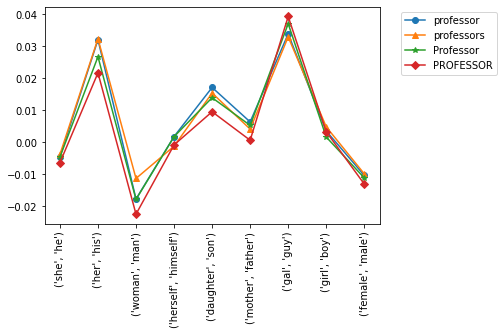

In [36]:
def_pairs = [('she','he'), ('her', 'his'), ('woman', 'man'), 
              ('herself', 'himself'),('daughter', 'son'), ('mother', 'father'), ('gal','guy'), 
              ('girl', 'boy'), ('female', 'male')]
#oa_mean = -0.54284024
#oa_std = 1.3037229
def plural(word):
    if word.endswith('y'):
        return word[:-1] + 'ies'
    elif word[-1] in 'sx' or word[-2:] in ['sh', 'ch']:
        return word + 'es'
    elif word.endswith('an'):
        return word[:-2] + 'en'
    else:
        return word + 's'
def prof_words(prof):
    prof_words = [prof]
    prof_words.append(plural(prof))
    prof_words.append(prof.capitalize())
    prof_words.append(prof.upper())
    return prof_words

length = len(def_pairs)
x = np.arange(length)
fig = plt.figure()
ax = plt.subplot(111)
graph_types = ["-o", "-^", "-*", "-D"]
#scores = ["-3.0180273","-3.0180273","0.171636","-3.0180273","-3.0180273","-3.0180273","-3.0180273","-3.0180273","-3.0180273","-3.0180273"]
#plt.plot(x, scores, graph_types[0], label = word)
gword_list = prof_words("professor")
for i,word in enumerate(gword_list):
    print(word)
    graph_type = graph_types[i]      
    #plt.title("DB/WA")
    scores = sims(word)#([bias_score("GGG is a XXX.", [pair[0], pair[1]], word)[2] for pair in def_pairs])
    print(scores)
    plt.plot(x, scores, graph_types[i], label = word)
            
#plt.plot(x, [oa_mean for i in range(length)], "g--", label = "mean")
#plt.plot(x, [oa_mean-oa_std for i in range(length)], "-.",color = "orange", label = "1 standard deviation")
#plt.plot(x, [oa_mean+oa_std for i in range(length)],  "-.",color = "orange", label =  "")
#plt.plot(x, [oa_mean-2*oa_std for i in range(length)],  "r:", label = "2 standard deviations")
#plt.plot(x, [oa_mean+2*oa_std for i in range(length)],  "r:", label = "")
plt.xticks(x, def_pairs, rotation='vertical')

#if leg == True:
plt.legend()
ax.legend(bbox_to_anchor=(1.05, 1.0))
plt.show()

In [72]:
# DIFFERENT FORMS BASE PAIRS ('herself', 'himself'),('daughter', 'son'), ('mother', 'father'), ('gal','guy'), ('girl', 'boy'), ('female', 'male')('herself', 'himself'),('daughter', 'son'), ('mother', 'father'),
# compare profession scores with using capitalized versions of base pairs eg (she, he) vs (She, He)
#import numpy as np
#np.seterr(divide='ignore',invalid='ignore')

def_pairs = [('she','he'), ('her', 'his'), ('woman', 'man'), 
              ('herself', 'himself'),('daughter', 'son'), ('mother', 'father'), ('gal','guy'), 
              ('girl', 'boy'), ('female', 'male')]
cap_def_pairs = [(fp.capitalize(), mp.capitalize()) for fp,mp in def_pairs]
# DIFFERENT FORMS BASE PAIRS
# compare profession scores with using capitalized versions of base pairs eg (she, he) vs (She, He)
from sklearn.metrics import cohen_kappa_score

#cap_def_pairs = [(fp.capitalize(), mp.capitalize()) for fp,mp in def_pairs]
# turn bias scores to directions (male or female)
def make_binary(df):
    binary_df = df.copy()
    binary_df[binary_df<0] = 0
    binary_df[binary_df>0] = 1
    return binary_df

# kappa for only two classes
def cohen_kappa(orign_df, vary_df):
    scores = []
    for i in range(len(orign_df.columns)):
        pair_cohen=cohen_kappa_score(orign_df[orign_df.columns[i]], vary_df[vary_df.columns[i]])
        scores.append(pair_cohen)
        print(pair_cohen)
        #print('& %.2f '%(pair_cohen), end=' ')
    print('& %.2f '%(np.mean(scores)))

def make_weat_scores_dict(word_pairs, word_list):
    weat_scores = {}
    i = 0
    for pair in word_pairs:
        weat_scores[pair] = []
    for word in word_list:
        score = sims(word)#bias_score("GGG is a XXX.", [pair[0], pair[1]], word)[2]#bdb(word, pair)
        #print(score)
        for pair in word_pairs:
            #weat_scores[pair] = []
            #print(pair)
            #print(score[i])
            weat_scores[pair].append(score[i])
            i = i + 1
        i = 0       
    return weat_scores
def make_Weat_scores_dict(word_pairs, word_list):
    weat_scores = {}
    i = 0
    for pair in word_pairs:
        weat_scores[pair] = []
    for word in word_list:
        score = simsS(word)#bias_score("GGG is a XXX.", [pair[0], pair[1]], word)[2]#bdb(word, pair)
        #print(score)
        for pair in word_pairs:
            weat_scores[pair].append(score[i])
            i = i + 1
        i = 0
    return weat_scores

# make score dataframes
l1 = ["worker","profoessor"]
weat_profs_scores = make_weat_scores_dict(def_pairs, l)
weat_profs_scores_cap = make_Weat_scores_dict(cap_def_pairs, l)

df_weat_prof = pd.DataFrame.from_dict(weat_profs_scores, orient='index', columns = l).T
df_weat_prof_cap = pd.DataFrame.from_dict(weat_profs_scores_cap, orient='index', columns = l).T

#outputpath='C:/Users/Mac/Desktop/contextual_embedding_bias_measure-master/prof.csv'
#df_weat_prof.to_csv(outputpath,sep=',',index=False,header=False)
#outputpaths='C:/Users/Mac/Desktop/contextual_embedding_bias_measure-master/prof_cap.csv'
#df_weat_prof_cap.to_csv(outputpaths,sep=',',index=False,header=False)

print("WEAT")
cohen_kappa(make_binary(df_weat_prof),make_binary(df_weat_prof_cap))

WEAT
0.31682322801024765
nan
0.357060849598163
0.0
nan
-0.02841677943166432
nan
0.18186610437532946
0.0
& nan 


In [69]:
from sklearn.metrics import cohen_kappa_score
def_pairs = [('she','he'), ('her', 'his'), ('woman', 'man'), 
              ('herself', 'himself'),('daughter', 'son'), ('mother', 'father'), ('gal','guy'), 
              ('girl', 'boy'), ('female', 'male')]
def make_binary(df):
    binary_df = df.copy()
    binary_df[binary_df<0] = 0
    binary_df[binary_df>0] = 1
    return binary_df
# kappa for only two classes
def cohen_kappa(orign_df, vary_df):
    scores = []
    for i in range(len(orign_df.columns)):
        pair_cohen=cohen_kappa_score(orign_df[orign_df.columns[i]], vary_df[vary_df.columns[i]])
        scores.append(pair_cohen)
        print('& %.2f '%(pair_cohen), end=' ')
    print('& %.2f '%(np.mean(scores)))

# base form words
weat_profsvb_scores = make_weat_scores_dict(def_pairs, l)
df_weat_profvb = pd.DataFrame.from_dict(weat_profsvb_scores, orient='index', columns = l).T


# plural form words
weat_profspl_scores = make_weat_scores_dict(def_pairs, professions_variants_pl)
df_weat_profpl = pd.DataFrame.from_dict(weat_profspl_scores, orient='index', columns = l).T

print("Base vs Plural")
print("WEAT")
cohen_kappa(make_binary(df_weat_profvb),make_binary(df_weat_profpl))

Base vs Plural
WEAT
& 0.65  & nan  & 0.28  & 0.41  & nan  & 0.53  & nan  & 0.66  & nan  & nan 


In [70]:
weat_profscap_scores = make_weat_scores_dict(def_pairs, professions_variants_cap)
df_weat_profcap = pd.DataFrame.from_dict(weat_profscap_scores, orient='index', columns = l).T

print("Base vs Capital")
print("WEAT")
cohen_kappa(make_binary(df_weat_profvb),make_binary(df_weat_profcap))

Base vs Capital
LPBS
& 0.58  & nan  & 0.50  & 0.45  & nan  & 0.26  & nan  & 0.43  & nan  & nan 


In [71]:
weat_profsupp_scores = make_weat_scores_dict(def_pairs, professions_variants_upper)
df_weat_profupp = pd.DataFrame.from_dict(weat_profsupp_scores, orient='index', columns = l).T

print("Base vs Upper")
print("WEAT")
cohen_kappa(make_binary(df_weat_profvb),make_binary(df_weat_profupp))

Base vs Upper
WEAT
& -0.02  & nan  & 0.00  & -0.06  & nan  & 0.02  & nan  & 0.04  & nan  & nan 
